In [2]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

In [16]:
from matplotlib import colors

In [3]:
import dask
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client(memory_limit="35GB")

In [4]:
from sklearn import linear_model
def diurnal_regression(var):
    var = var.transpose('hour','lat','lon')
    nh,nlat,nlon = var.shape 
    omega = 2*np.pi/24
    preds = np.vstack((np.cos(omega*var.hour),np.sin(omega*var.hour))).transpose()
    model_ols =  linear_model.LinearRegression()
    model_ols.fit(preds,np.array(var).reshape((nh,-1)))
    dummy_ar = var.isel(hour=0)**0
    beta1 = dummy_ar * (model_ols.coef_[:,0]).reshape((nlat,nlon))
    beta2 = dummy_ar * (model_ols.coef_[:,1]).reshape((nlat,nlon))
    intercept = dummy_ar * (model_ols.intercept_).reshape((nlat,nlon))
    amplitude = np.sqrt(beta1**2+beta2**2).rename('amplitude')
    phase = np.mod( ((np.arctan(beta2/beta1) + (np.sign(beta1)<0)*np.pi)/omega) , 24).rename('phase')
    intercept = intercept.rename('intercept')
    return xr.merge((amplitude,phase,intercept))

In [5]:
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81


In [6]:
from scipy.ndimage import gaussian_filter
gpm_seasmean = xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")
gpm_seasmean_smooth = xr.apply_ufunc(lambda img:gaussian_filter(img,5),gpm_seasmean,input_core_dims=[['latitude','longitude']], output_core_dims=[['latitude','longitude']],vectorize=True)
gpm_seasmean_e5 = gpm_seasmean.interp_like(orogm)

In [7]:
era5100u_seasmean = xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
era5100v_seasmean = xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")

In [46]:
def add_wind(ax,u,v,color='k',width=0.001,scale=600):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=20
    m=20
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    ax.quiverkey(q, 0.87, 1.03, 10, r'10 m s$^{-1}$', labelpos='E', coordinates='axes',color='k')

# Precip diurnal cycle strength

In [4]:
m=11
ti = time.time()
for y in range(2001,2021):
    gpmjul = xr.open_mfdataset(CMIP6_FOLDER+"GPM/{}/3B-HHR.MS.MRG.3IMERG.{}{:>02}*.V06B.HDF5.nc4".format(y,y,m),parallel=True).precipitationCal.sel(lat=slice(-30,30))
    gpmjuldc = gpmjul.groupby('time.hour').mean().compute()
    (gpmjuldc*24).to_dataset(name='pr').to_zarr("/global/cscratch1/sd/qnicolas/tropicsData/GPM.3IMERG.VO6B.{}{:>02}.diurnalcycle.zarr".format(y,m))
    print(time.time()-ti);ti=time.time()

65.9588098526001
42.70950698852539
46.18679332733154
51.85715913772583
57.531949520111084
45.30899453163147
45.58684229850769
49.46203947067261
50.74119305610657
45.89624214172363
47.065215826034546
46.92256140708923
45.360079288482666
52.616724252700806
46.462822675704956
46.29989719390869
46.83465814590454
44.46979856491089


## July

In [9]:
m=7
dcs7 = 0
for y in range(2001,2021):
    dc = xr.open_zarr("/global/cscratch1/sd/qnicolas/tropicsData/GPM.3IMERG.VO6B.{}{:>02}.diurnalcycle.zarr".format(y,m)).pr
    dcs7+=diurnal_regression(dc)/20

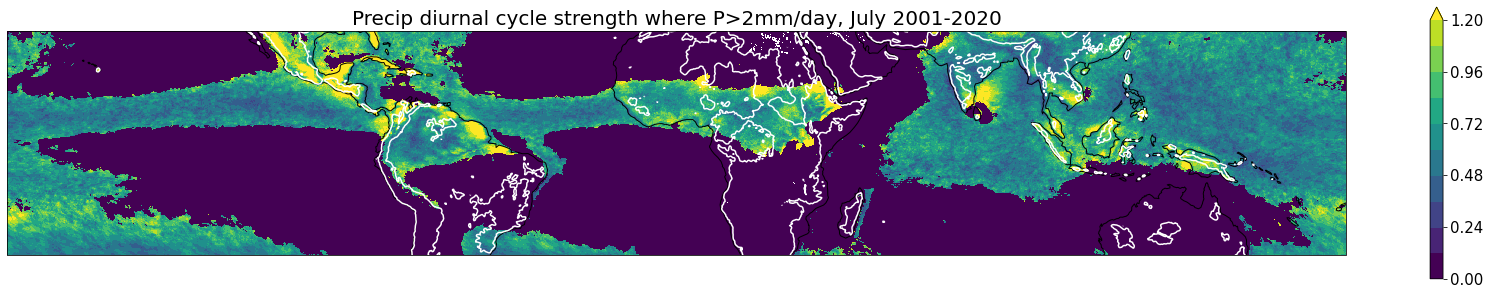

In [10]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')
((dcs7.amplitude/dcs7.intercept)*(dcs7.intercept>2)).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0,1.2,11))
ax.coastlines()
ax.set_title("Precip diurnal cycle strength where P>2mm/day, July 2001-2020",fontsize=20);None

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


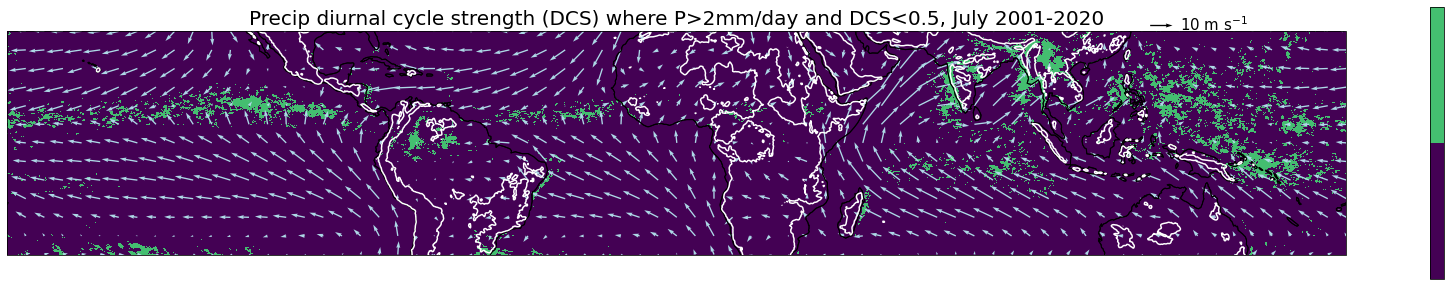

In [27]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')
((dcs7.intercept>2)*((dcs7.amplitude/dcs7.intercept)<0.5)).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7]))),cbar_kwargs={'ticks':[]})
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7),'lightblue',width=0.001,scale=600)
ax.set_ylim(-30,30)
ax.coastlines()
ax.set_title("Precip diurnal cycle strength (DCS) where P>2mm/day and DCS<0.5, July 2001-2020",fontsize=20);None

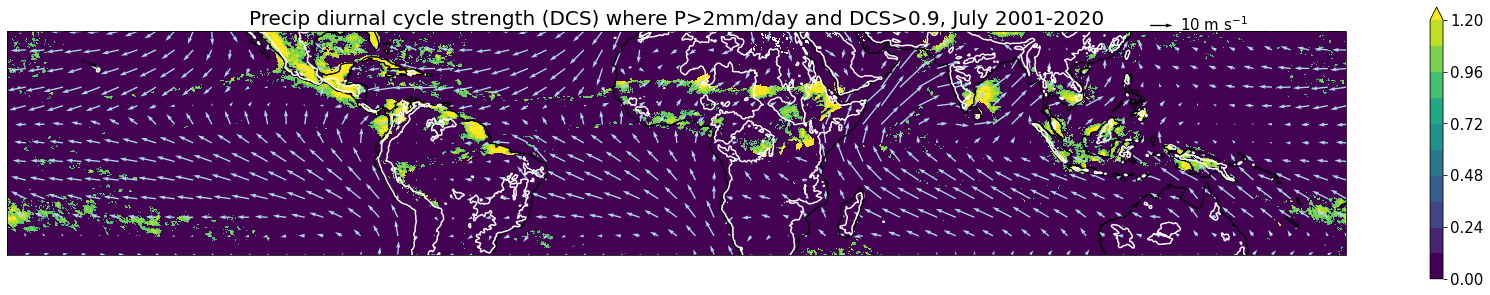

In [12]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')
((dcs7.amplitude/dcs7.intercept)*(dcs7.intercept>2)*((dcs7.amplitude/dcs7.intercept)>0.9)).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0,1.2,11))
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7),'lightblue',width=0.001,scale=600)
ax.set_ylim(-30,30)
ax.coastlines()
ax.set_title("Precip diurnal cycle strength (DCS) where P>2mm/day and DCS>0.9, July 2001-2020",fontsize=20);None

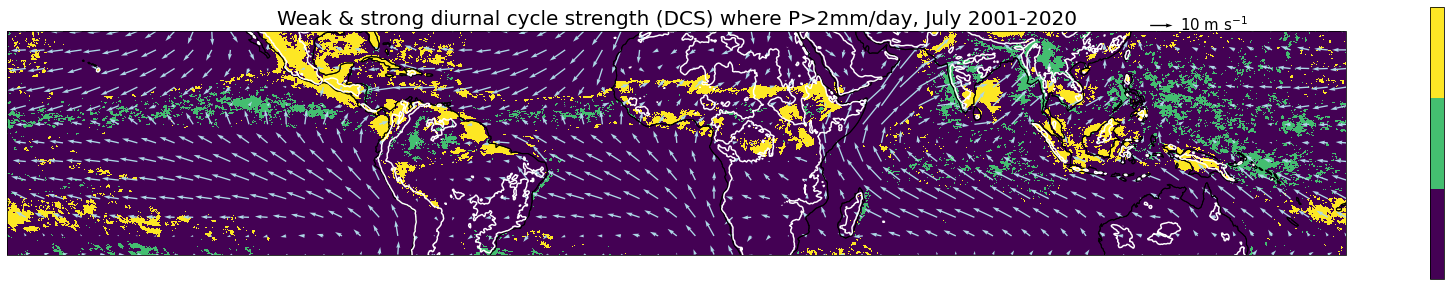

In [32]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')

((dcs7.intercept>2)*( 0.5*((dcs7.amplitude/dcs7.intercept)<0.5) + ((dcs7.amplitude/dcs7.intercept)>0.9) )).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7,1]))),cbar_kwargs={'ticks':[]})
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7),'lightblue',width=0.001,scale=600)
ax.set_ylim(-30,30)
ax.coastlines()
ax.set_title("Weak & strong diurnal cycle strength (DCS) where P>2mm/day, July 2001-2020",fontsize=20);None

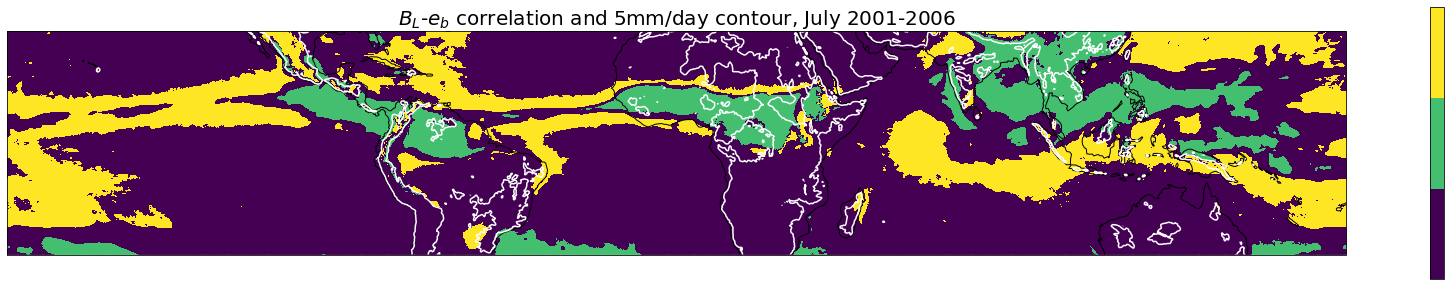

In [136]:
gpm_seasmean_smooth= gpm_seasmean_smooth
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
((gpm_seasmean_e5.sel(month=7)>2)*(0.5*(ebBlcorr<0.3) + 1*(ebBlcorr>0.6))).plot(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7,1]))),cbar_kwargs={'ticks':[]})
orogm.plot.contour(levels=[500.],colors='w')
ax.coastlines()
ax.set_ylim(-30,30)
ax.set_title(r"$B_L$-$e_b$ correlation and 5mm/day contour, July 2001-2006",fontsize=20);None

## November

In [30]:
m=11
dcs11 = 0
for y in range(2001,2021):
    dc = xr.open_zarr("/global/cscratch1/sd/qnicolas/tropicsData/GPM.3IMERG.VO6B.{}{:>02}.diurnalcycle.zarr".format(y,m)).pr
    dcs11+=diurnal_regression(dc)/20

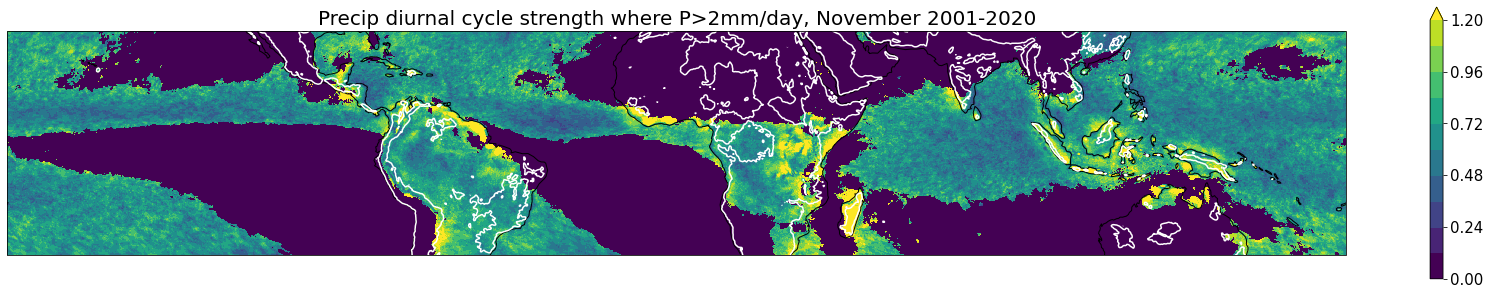

In [42]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')
((dcs11.amplitude/dcs11.intercept)*(dcs11.intercept>2)).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0,1.2,11))
ax.coastlines()
ax.set_title("Precip diurnal cycle strength where P>2mm/day, November 2001-2020",fontsize=20);None

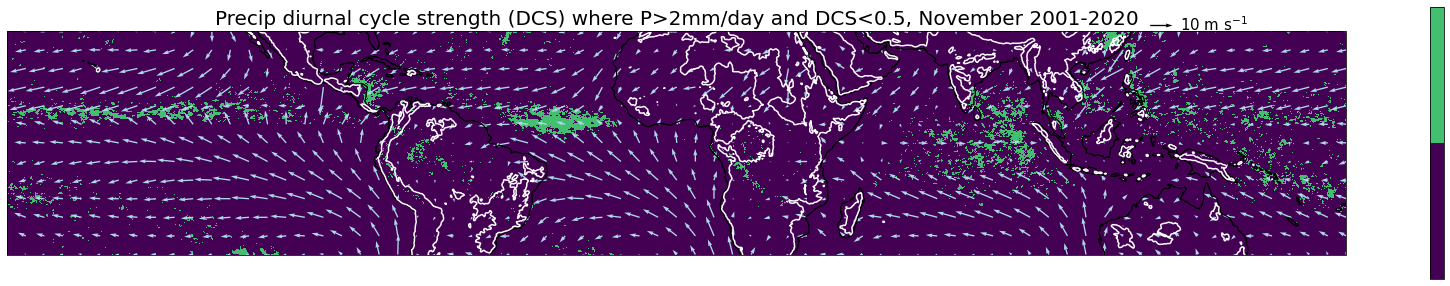

In [33]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')
((dcs11.intercept>2)*((dcs11.amplitude/dcs11.intercept)<0.5)).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7]))),cbar_kwargs={'ticks':[]})
add_wind(ax,era5100u_seasmean.sel(month=11),era5100v_seasmean.sel(month=11),'lightblue',width=0.001,scale=600)
ax.set_ylim(-30,30)
ax.coastlines()
ax.set_title("Precip diurnal cycle strength (DCS) where P>2mm/day and DCS<0.5, November 2001-2020",fontsize=20);None

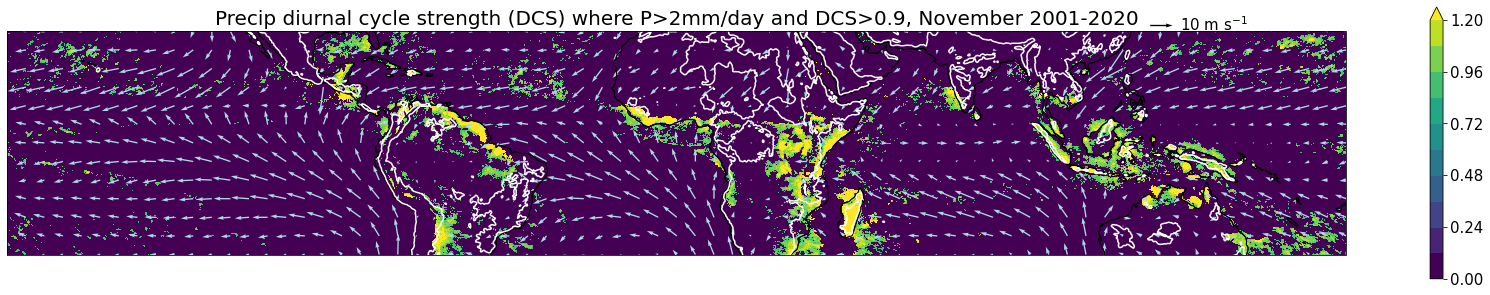

In [43]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')
((dcs11.amplitude/dcs11.intercept)*(dcs11.intercept>2)*((dcs11.amplitude/dcs11.intercept)>0.9)).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0,1.2,11))
add_wind(ax,era5100u_seasmean.sel(month=11),era5100v_seasmean.sel(month=11),'lightblue',width=0.001,scale=600)
ax.set_ylim(-30,30)
ax.coastlines()
ax.set_title("Precip diurnal cycle strength (DCS) where P>2mm/day and DCS>0.9, November 2001-2020",fontsize=20);None

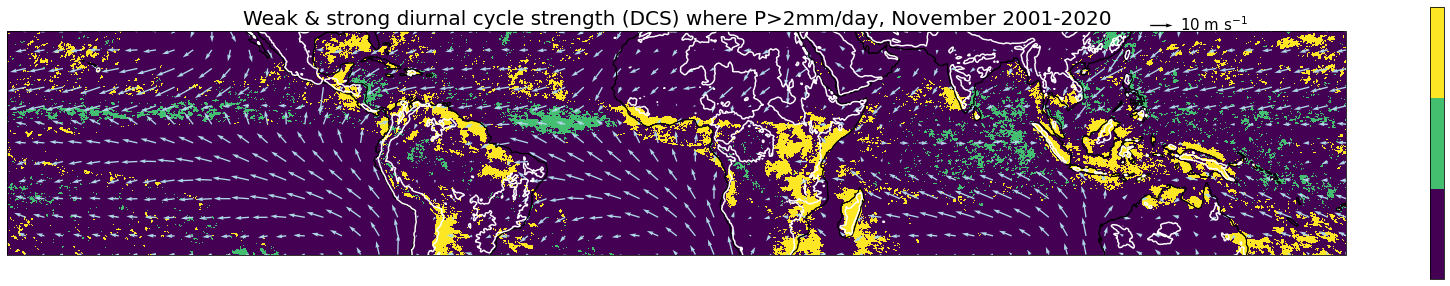

In [31]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')

((dcs11.intercept>2)*( 0.5*((dcs11.amplitude/dcs11.intercept)<0.5) + ((dcs11.amplitude/dcs11.intercept)>0.9) )).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7,1]))),cbar_kwargs={'ticks':[]})
add_wind(ax,era5100u_seasmean.sel(month=11),era5100v_seasmean.sel(month=11),'lightblue',width=0.001,scale=600)
ax.set_ylim(-30,30)
ax.coastlines()
ax.set_title("Weak & strong diurnal cycle strength (DCS) where P>2mm/day, November 2001-2020",fontsize=20);None

# $e_b$,$T_L$,$q_L$ - $B_L$ correlation

In [37]:
alpha = 20.6/3600*2.5e6
dBLdqL = 1/(11.3*3600)*1004*8000/alpha
dBLdTL = -1/(2.7*3600)*1004*8000/alpha
dBLdeb = 1/(11.5*3600)*1004*8000/alpha

In [38]:
from scipy import special
def linregress_xr_2(x,y):
    nt = len(x.time)
    assert nt==len(y.time)
    ssxm = nt*x.var(dim='time')
    ssym = nt*y.var(dim='time')
    ssxym = nt*xr.cov(x,y,dim='time')
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 * x.isel(time=0)**0
    
    return xr.merge([slope.rename('slope'),(r**2).rename('rsquared'),pval.rename('pvalue')])

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

In [41]:
m=7;years=range(2001,2006)
BL = xr.concat([xr.open_zarr("/global/cscratch1/sd/qnicolas/tropicsData/e5.diagnostic.BL.{}{:>02}.tropics.zarr".format(y,m)).BL for y in years],dim='time')
tL = xr.concat([xr.open_zarr("/global/cscratch1/sd/qnicolas/tropicsData/e5.diagnostic.tL.{}{:>02}.tropics.zarr".format(y,m)).tL for y in years],dim='time')
qL = xr.concat([xr.open_zarr("/global/cscratch1/sd/qnicolas/tropicsData/e5.diagnostic.qL.{}{:>02}.tropics.zarr".format(y,m)).qL for y in years],dim='time')
tb = xr.concat([xr.open_zarr("/global/cscratch1/sd/qnicolas/tropicsData/e5.diagnostic.tb.{}{:>02}.tropics.zarr".format(y,m)).tb for y in years],dim='time')
qb = xr.concat([xr.open_zarr("/global/cscratch1/sd/qnicolas/tropicsData/e5.diagnostic.qb.{}{:>02}.tropics.zarr".format(y,m)).qb for y in years],dim='time')
eb=tb+2.5e3*qb

In [48]:
ebBlcorr = xr.corr(eb,BL,dim='time')
tLBlcorr = xr.corr(tL,BL,dim='time')
qLBlcorr = xr.corr(qL,BL,dim='time')

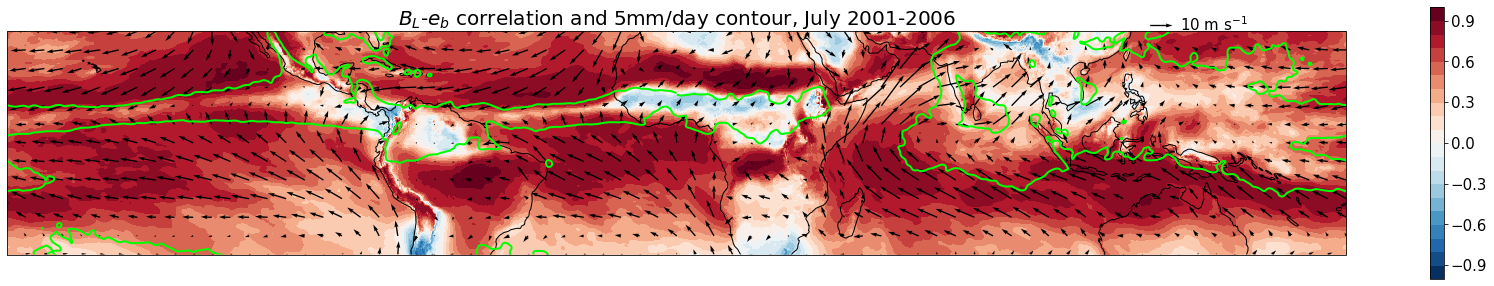

In [81]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
ebBlcorr.plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-1.,1.,21))
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7))
gpm_seasmean_smooth.sel(month=7).plot.contour(ax=ax,levels=[5.],colors=['lime'],linewidths=[2],transform=ccrs.PlateCarree())
ax.set_ylim(-30,30)
ax.set_title(r"$B_L$-$e_b$ correlation and 5mm/day contour, July 2001-2006",fontsize=20);None

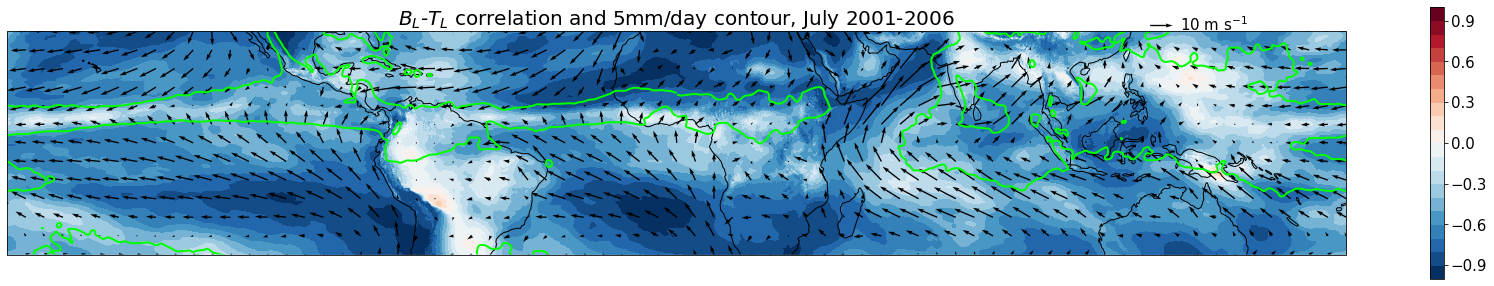

In [82]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
tLBlcorr.plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-1.,1.,21))
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7))
gpm_seasmean_smooth.sel(month=7).plot.contour(ax=ax,levels=[5.],colors=['lime'],linewidths=[2],transform=ccrs.PlateCarree())
ax.set_ylim(-30,30)
ax.set_title(r"$B_L$-$T_L$ correlation and 5mm/day contour, July 2001-2006",fontsize=20);None

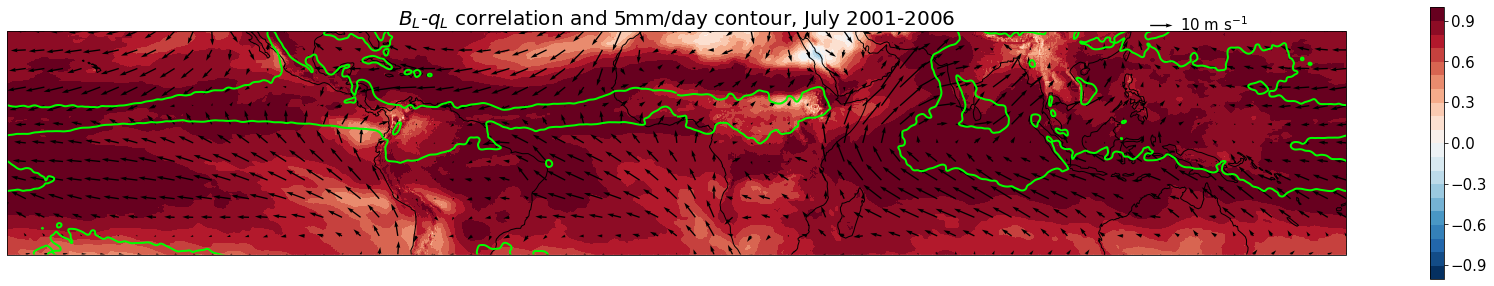

In [83]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
qLBlcorr.plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-1.,1.,21))
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7))
gpm_seasmean_smooth.sel(month=7).plot.contour(ax=ax,levels=[5.],colors=['lime'],linewidths=[2],transform=ccrs.PlateCarree())
ax.set_ylim(-30,30)
ax.set_title(r"$B_L$-$q_L$ correlation and 5mm/day contour, July 2001-2006",fontsize=20);None

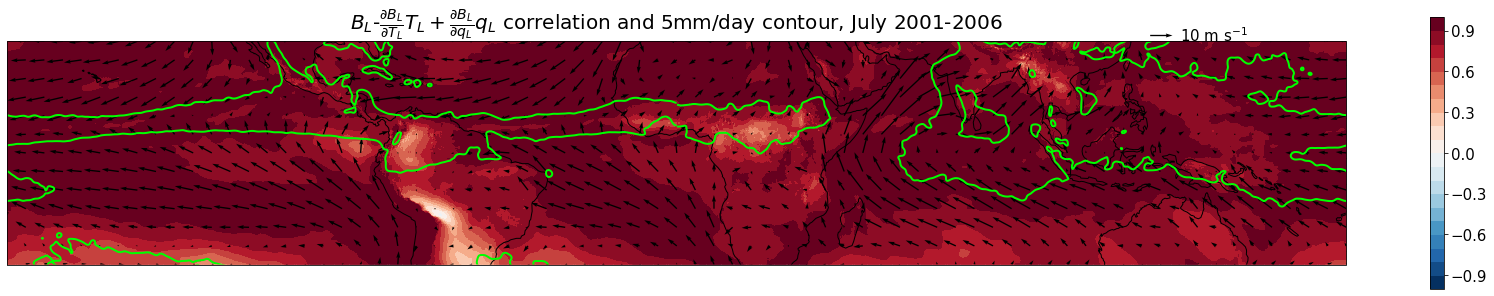

In [96]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
xr.corr(2.5e3*dBLdqL*(qL-qL.mean('time'))+dBLdTL*(tL-tL.mean('time')),BL-BL.mean('time'),dim='time').plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-1.,1.,21))
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7))
gpm_seasmean_smooth.sel(month=7).plot.contour(ax=ax,levels=[5.],colors=['lime'],linewidths=[2],transform=ccrs.PlateCarree())
ax.set_ylim(-30,30)
ax.set_title(r"$B_L$-$\frac{\partial B_L}{\partial T_L}T_L+\frac{\partial B_L}{\partial q_L}q_L$ correlation and 5mm/day contour, July 2001-2006",fontsize=20);None

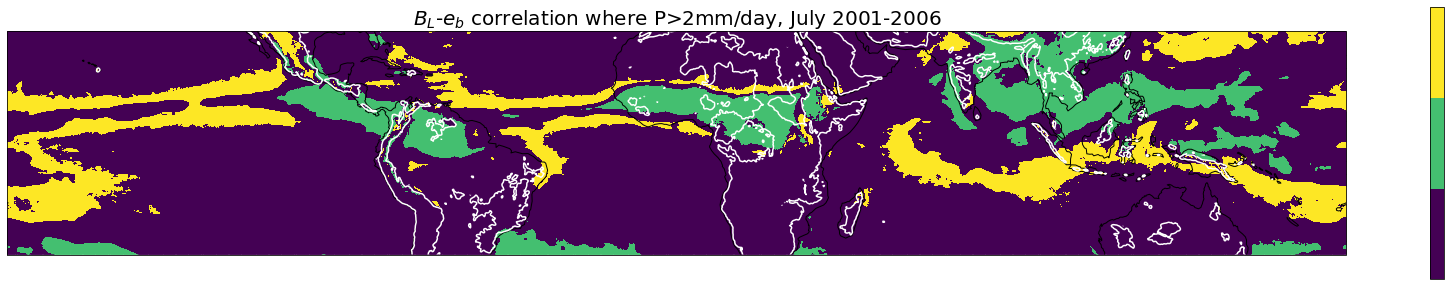

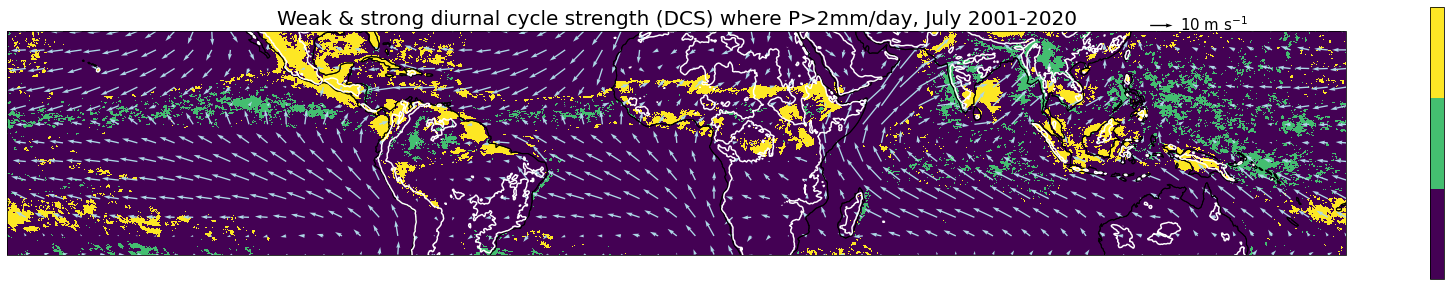

In [156]:
gpm_seasmean_smooth= gpm_seasmean_smooth
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
((gpm_seasmean_e5.sel(month=7)>2)*(0.5*(ebBlcorr<0.3) + 1*(ebBlcorr>0.7))).plot(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7,1]))),cbar_kwargs={'ticks':[]})
orogm.plot.contour(levels=[500.],colors='w')
ax.coastlines()
ax.set_ylim(-30,30)
ax.set_title(r"$B_L$-$e_b$ correlation where P>2mm/day, July 2001-2006",fontsize=20);None

fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')

((dcs7.intercept>2)*( 0.5*((dcs7.amplitude/dcs7.intercept)<0.5) + ((dcs7.amplitude/dcs7.intercept)>0.9) )).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7,1]))),cbar_kwargs={'ticks':[]})
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7),'lightblue',width=0.001,scale=600)
ax.set_ylim(-30,30)
ax.coastlines()
ax.set_title("Weak & strong diurnal cycle strength (DCS) where P>2mm/day, July 2001-2020",fontsize=20);None

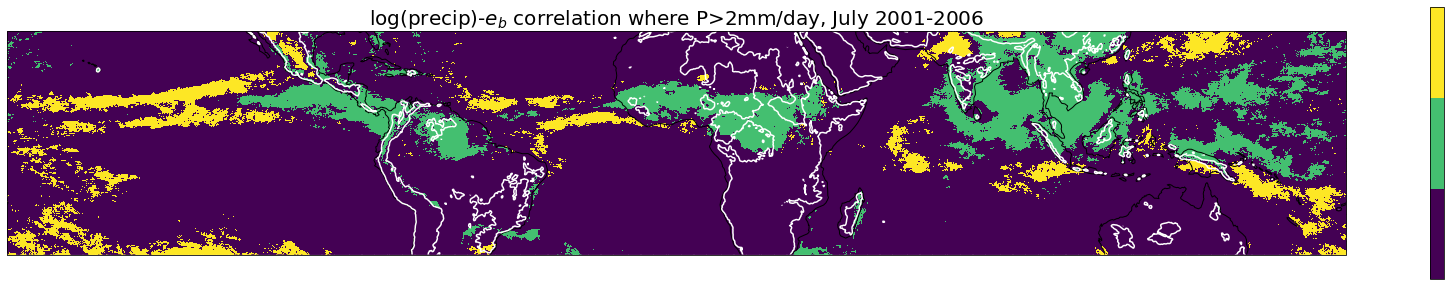

In [154]:
gpm_seasmean_smooth= gpm_seasmean_smooth
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
((gpm_seasmean_e5.sel(month=7)>2)*(0.5*(eblnprcorr<0.2) + 1*(eblnprcorr>0.5))).plot(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7,1]))),cbar_kwargs={'ticks':[]})
orogm.plot.contour(levels=[500.],colors='w')
ax.coastlines()
ax.set_ylim(-30,30)
ax.set_title(r"log(precip)-$e_b$ correlation where P>2mm/day, July 2001-2006",fontsize=20);None

fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')

((dcs7.intercept>2)*( 0.5*((dcs7.amplitude/dcs7.intercept)<0.5) + ((dcs7.amplitude/dcs7.intercept)>0.9) )).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7,1]))),cbar_kwargs={'ticks':[]})
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7),'lightblue',width=0.001,scale=600)
ax.set_ylim(-30,30)
ax.coastlines()
ax.set_title("Weak & strong diurnal cycle strength (DCS) where P>2mm/day, July 2001-2020",fontsize=20);None

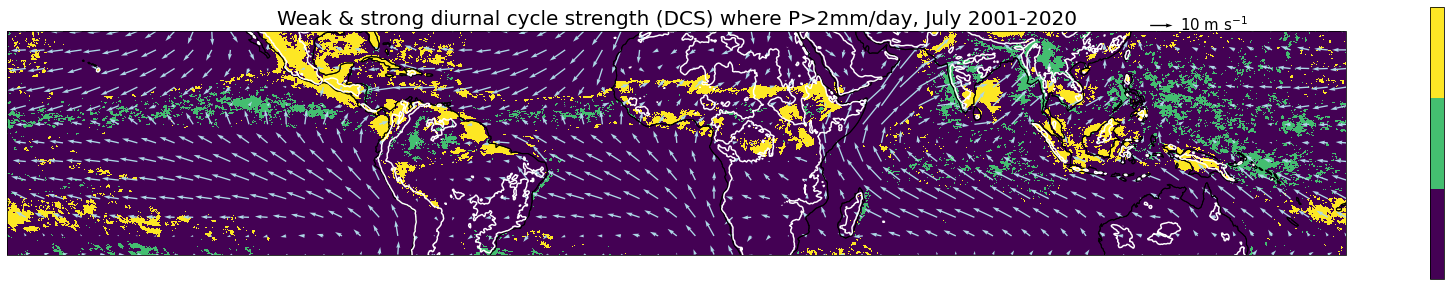

In [32]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
orogm.plot.contour(levels=[500.],colors='w')

((dcs7.intercept>2)*( 0.5*((dcs7.amplitude/dcs7.intercept)<0.5) + ((dcs7.amplitude/dcs7.intercept)>0.9) )).plot.imshow(ax=ax,transform=ccrs.PlateCarree(),cmap = colors.ListedColormap(plt.cm.viridis(np.array([0,0.7,1]))),cbar_kwargs={'ticks':[]})
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7),'lightblue',width=0.001,scale=600)
ax.set_ylim(-30,30)
ax.coastlines()
ax.set_title("Weak & strong diurnal cycle strength (DCS) where P>2mm/day, July 2001-2020",fontsize=20);None

# $e_b$,$T_L$,$q_L$ - precip correlation

In [74]:
gpmpr07 = xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/pnicknis/gpm/daily/3B-DAY.MS.MRG.3IMERG.200[1-5]07*-S000000-E235959.V06.nc4")),parallel=True).precipitationCal.rename({'lat':'latitude','lon':'longitude'}).transpose('time','latitude','longitude')
gpmpr07 = gpmpr07.rename({'time':'oldtime'}).assign_coords({'time':('oldtime',tL.time)}).swap_dims({'oldtime':'time'})
gpmpr07['longitude'] = gpmpr07['longitude']%360
gpmpr07 = gpmpr07.sortby('longitude')
gpmpr07_e5grid = gpmpr07.interp_like(tL.isel(time=0)).compute()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [77]:
ebprcorr = xr.corr(eb,gpmpr07_e5grid,dim='time')
tLprcorr = xr.corr(tL,gpmpr07_e5grid,dim='time')
qLprcorr = xr.corr(qL,gpmpr07_e5grid,dim='time')
BLprcorr = xr.corr(BL,gpmpr07_e5grid,dim='time')

In [139]:
eblnprcorr = xr.corr(eb,np.log(gpmpr07_e5grid+1e-5),dim='time')
tLlnprcorr = xr.corr(tL,np.log(gpmpr07_e5grid+1e-5),dim='time')
qLlnprcorr = xr.corr(qL,np.log(gpmpr07_e5grid+1e-5),dim='time')
BLlnprcorr = xr.corr(BL,np.log(gpmpr07_e5grid+1e-5),dim='time')

In [102]:
def get_bins(var,nbins):
    var_sorted = sorted(np.array(var).reshape(-1))
    quantiles=np.linspace(0.,len(var)-1,nbins+1)
    bins = [var_sorted[int(i)]  for i in quantiles]
    bin_centers = [np.mean(var_sorted[int(quantiles[i]):int(quantiles[i+1])]) for i in range(len(quantiles)-1)]
    return np.array(bins)#,np.array(bin_centers)

def get_binned(a,b,bins):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    return bin_centers,bin_means

def get_count(a,bins):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    count = np.histogram(a,bins)[0]
    return bin_centers,count

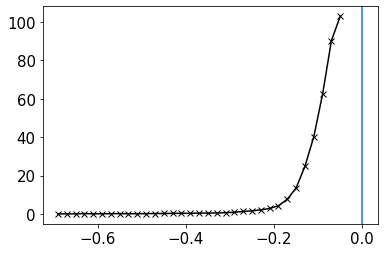

In [110]:
BLs = np.array(BL.sel(latitude=slice(10,-10),longitude=slice(150,180))).reshape(-1)
prs = np.array(gpmpr07_e5grid.sel(latitude=slice(10,-10),longitude=slice(150,180))).reshape(-1)
bin_centers,bin_means = get_binned(BLs,prs,np.linspace(-0.7,0.1,41))
#plt.scatter(BLs,prs)
plt.plot(bin_centers,bin_means,'-xk')
plt.axvline(0.)
            

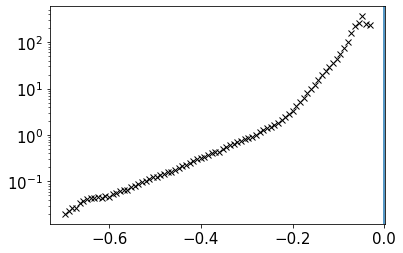

In [115]:
BLs = np.array(BL.sel(latitude=slice(20,-20),longitude=slice(100,180))).reshape(-1)
prs = np.array(gpmpr07_e5grid.sel(latitude=slice(20,-20),longitude=slice(100,180))).reshape(-1)
bin_centers,bin_means = get_binned(BLs,prs,np.linspace(-0.7,0.1,101))
#plt.scatter(BLs,prs)
plt.plot(bin_centers,bin_means,'xk')
plt.yscale('log')
plt.axvline(0.)
            

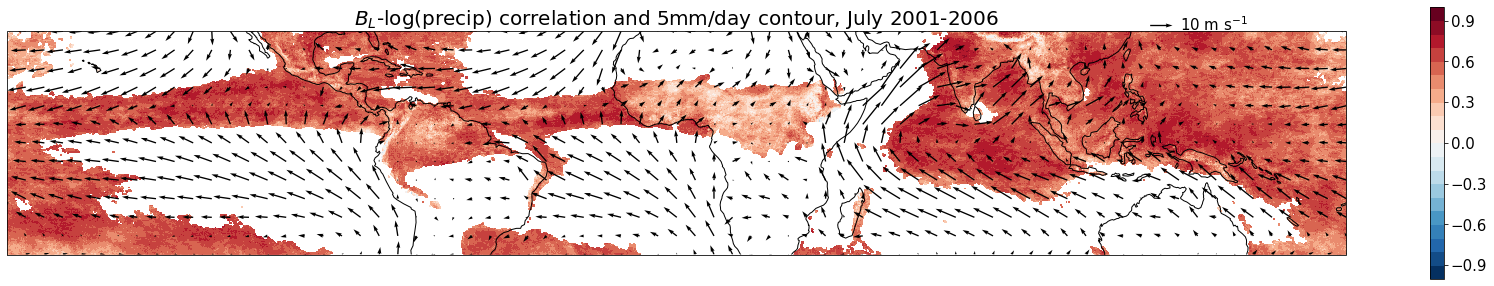

In [147]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
(BLlnprcorr.where(gpm_seasmean_e5.sel(month=7)>2)).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-1.,1.,21))
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7))
ax.set_ylim(-30,30)
ax.set_title(r"$B_L$-log(precip) correlation and 5mm/day contour, July 2001-2006",fontsize=20);None

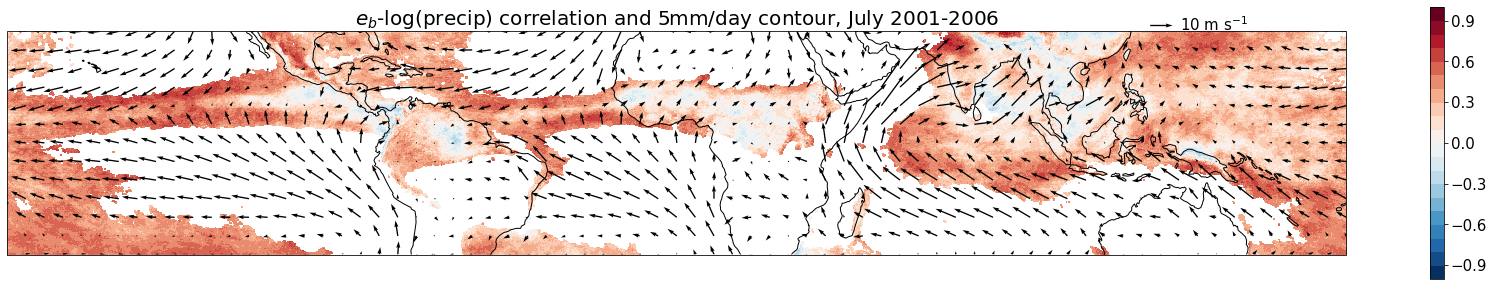

In [148]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
(eblnprcorr.where(gpm_seasmean_e5.sel(month=7)>2)).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-1.,1.,21))
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7))
ax.set_ylim(-30,30)
ax.set_title(r"$e_b$-log(precip) correlation and 5mm/day contour, July 2001-2006",fontsize=20);None

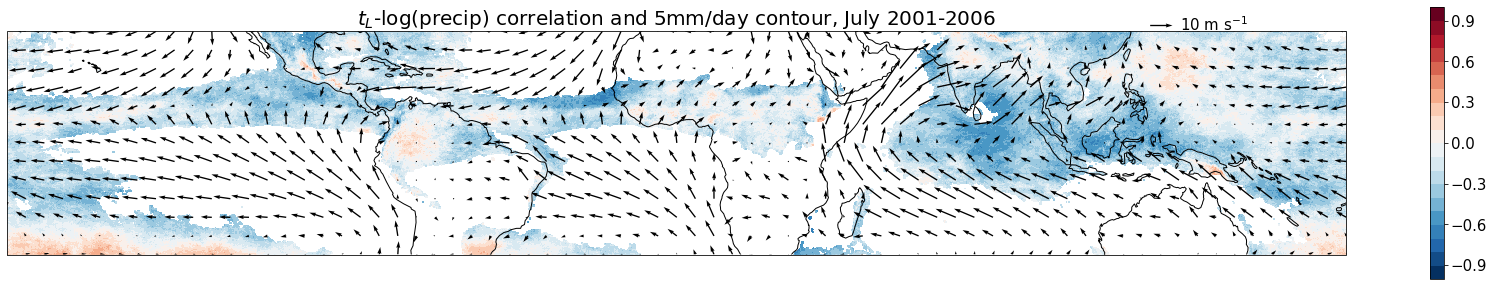

In [149]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
(tLlnprcorr.where(gpm_seasmean_e5.sel(month=7)>2)).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-1.,1.,21))
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7))
ax.set_ylim(-30,30)
ax.set_title(r"$t_L$-log(precip) correlation and 5mm/day contour, July 2001-2006",fontsize=20);None

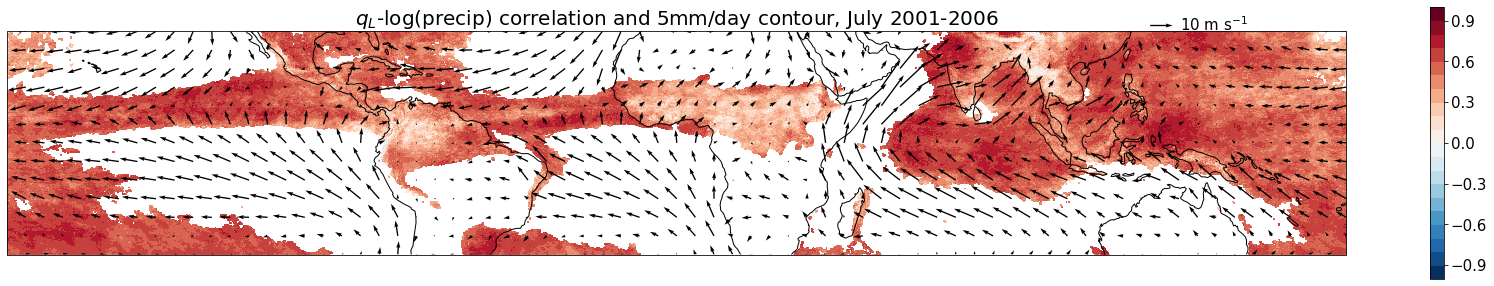

In [152]:
fig,ax = plt.subplots(1,1,figsize=(30,5),subplot_kw={"projection":ccrs.PlateCarree()})
(qLlnprcorr.where(gpm_seasmean_e5.sel(month=7)>2)).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-1.,1.,21))
add_wind(ax,era5100u_seasmean.sel(month=7),era5100v_seasmean.sel(month=7))
ax.set_ylim(-30,30)
ax.set_title(r"$q_L$-log(precip) correlation and 5mm/day contour, July 2001-2006",fontsize=20);None

# Later: all months

(-30.0, 30.0)

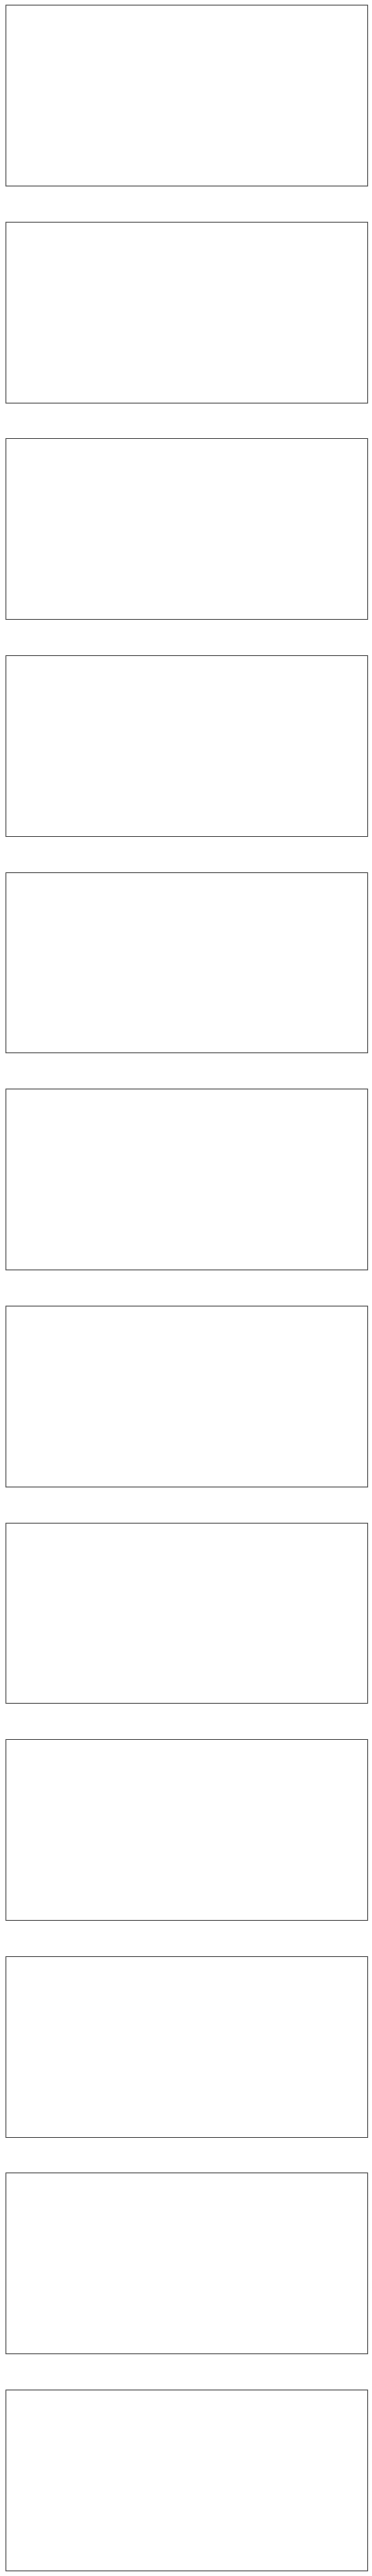

In [73]:
fig,axs = plt.subplots(6,2,figsize=(25,30),subplot_kw={"projection":ccrs.PlateCarree()})
for i,ax in enumerate(axs.reshape(-1)):
    #xr.corr(eb,BL,dim='time').plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-1.,1.,21))
    add_precip_wind(ax,gpm_seasmean_smooth.sel(month=i+1),era5100u_seasmean.sel(month=i+1),era5100v_seasmean.sel(month=i+1))
    ax.set_xlim(20,180)
    ax.set_ylim(-30,30)